# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=913caa9415e21305662681756751778932b70dba8d9356ca5dfb34217769fc55
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/u.item          
   creating: __MACOSX/
   creating: __MACOSX/ml-100k/
  inflating: __MACOSX/ml-100k/._u.item  
  inflating: ml-100k/u3.test         
  inflating: __MACOSX/ml-100k/._u3.test  
  inflating: ml-100k/u1.base         
  inflating: __MACOSX/ml-100k/._u1.base  
  inflating: ml-100k/u.info          
  inflating: __MACOSX/ml-100k/._u.info  
  inflating: ml-100k/u2.test         
  inflating: __MACOSX/ml-100k/._u2.test  
  inflating: ml-100k/u5.test         
  inflating: __MACOSX/ml-100k/._u5.test  
  inflating: ml-100k/u.genre         
  inflating: __MACOSX/ml-100k/._u.genre  
  inflating: ml-100k/ub.test         
  inflating: __MACOSX/ml-100k/._ub.test  
  inflating: ml-100k/ua.base         
  inflating: __MACOSX/ml-100k/._ua.base  
  inflating: ml-100k/u.data          
  inflating: __MACOSX/ml-100k/._u.data  
  inflating: ml-100k/README          
  inflating: __MACOSX/ml-100k/._README  
  inflating: ml-100k/u4.te

In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a) Building User-to-Item Rating Matrix

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating

    return matrix

In [17]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b) User Average/Popularity

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method #4
        self.method = self._getMethod(self.method_name) #3 train_matrix, num_users, num_items
        self.processor = processor #2
        self.pred_column_name = self.method_name #evaluate2
        
    def _getMethod(self, method_name): #5
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items): #6 average rating the user has given
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        for (user, item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                # select the row for user
                # what's the shape of userVector 1*number of all items
                userVector = train_matrix[user, :]
                ratedItems = userVector[userVector.nonzero()] #itemsha that have been rated by this user 
                #matrix.nonzero Return the indices of the elements that are non-zero.
                
                # If not empty, calculate average and set as rating for the current item
                if ratedItems.size == 0:
                    average_item = 0 
                else:
                    average_item = ratedItems.mean()
                predictionMatrix[user,item] = average_item
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
    
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items): #6 all items that do not have a rating will get a rating based 
    #on all user ratings of the item
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
       
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vp = np.vectorize(lambda x: 1 if x >= 4 else 0)

        # For every item calculate the number of people liked (4-5) divided by the number of people that rated  
        itemPopularity = np.zeros((num_items))

        for item in range(num_items):
            NumberOfUserRated = len(train_matrix[:,item].nonzero()[0])
            NumberOfUserLiked = len((vp(train_matrix[:, item]).nonzero()[0]))

            if NumberOfUserRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = NumberOfUserLiked/NumberOfUserRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items): #1
        
        train_matrix = self.processor(train_df, num_users, num_items) #User-to-Item Rating Matrix
        self.__model = self.method(train_matrix, num_users, num_items) #return the prediction matrix
        
    def evaluate_test(self, test_df, copy=False):  #evaluate1
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan #one of the two methods ['useraverge'] = 0
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1] #prediction matrix user--roll, item-- column

        return prediction
        
    def getModel(self): #7 get from predict_all, return the prediction model
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1168.98it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1167.24it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        converter = np.vectorize(lambda x: 1/((x+1))) #between [0,1]
        similarity_matrix = converter(pairwise_distances(matrix))
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        converter = np.vectorize(lambda x: 1/((x+1)))
        similarity_matrix = converter(pairwise_distances(matrix, 
                                                         metric='manhattan'))

        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':   
            similarity = self.method(train_matrix)        
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            # UxI: UxU mul UxI
            normalizer = np.matmul(similarity, temp_matrix) #number of users*number of items
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5 #10**-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            #why do we need a normalizer? 分子是rating*simi的和，我们只需要rating，simi加多了，所以要除掉
            predictionMatrix = np.matmul(similarity, train_matrix)/normalizer 
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            #numberof users*1
            #不会整除0
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5) #axis=1 tuple横着加 sum of user rating/#user
            columns = np.sum(predictionMatrix, axis=0) #sum of ratings for each item #1*number of items
            #print(columns.shape) 
            #把所有0update成average
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
                                             #columns这个matrix数列里数字是0的index对应的predictionMatrix
            self.__model = predictionMatrix
        
    
        elif self.base == 'item':
            train_matrix = train_matrix.T
            similarity = self.method(train_matrix)  #similarity of items
             # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            
            # UxI: UxU mul UxI
            normalizer = np.matmul(similarity, temp_matrix) #number of users*number of items
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5 #10**-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
    
            predictionMatrix = np.matmul(similarity, train_matrix)/normalizer #why do we need a normalizer?
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            #numberof users*1
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5) #axis=1 tuple横着加 sum of user rating/#user
            columns = np.sum(predictionMatrix, axis=0) #sum of ratings for each item #1*number of items
            #print(columns.shape) 
            #把所有0update成average
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
                                             #columns这个matrix数列里数字是0的index对应的predictionMatrix

            self.__model = predictionMatrix.T #return the prediction matrix


        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
a = np.array([2,3,4,5])+3
a

array([5, 6, 7, 8])

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3) #I dimension
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
a = ([0,2,1], [0,1,0])
columns = np.sum(a, axis=0) 
b = np.matrix(a)
print(columns)
b[:, columns == 0]

[0 3 1]


matrix([[0],
        [0]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

Cosine similarity works better because it uses angle instead of distance. The angle between the three points is zero whereas the distance is not. Even though user1 has nothing in common with user2 for item_i, their euclidean distance is still not zero. Further more, the euclidean distance is sensitive to similar vectors of different length. 

### (b) 
I choose Manhanttan distance as the thrid metric because it is less sensitive to distance than euclidean.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

74254it [01:08, 1099.64it/s]

### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name): #column_name: true, pred
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances_1 = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse_1 = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse_1.run(algorithm_instances_1, num_users, num_items,k=5)

In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
algorithm_instances_item_1 = [popularity_recsys, 
                       average_user_rating_recsys, 
                       item_cosine_recsys]

cv_rmse_1 = CrossValidation('RMSE')
cv_rmse_1.run(algorithm_instances_item_1, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2031.27it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2014.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2024.93it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2061.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2031.36it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2056.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2035.22it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2061.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2069.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2041.47it/s]


Processing algorithm item-cosine


20000it [00:10, 1961.56it/s]
20000it [00:09, 2015.20it/s]
20000it [00:09, 2031.37it/s]
20000it [00:09, 2036.27it/s]
20000it [00:09, 2039.78it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'popularity': [[3.177941281084362,
   3.1750480150769977,
   3.147474655005899,
   3.146164503024159,
   3.1488360007536382],
  3.1590928909890112,
  3.139292746995387,
  3.1788930349826354],
 'useraverage': [[1.0629951276561334,
   1.0467467492319966,
   1.0328964562995389,
   1.0366575971298078,
   1.0392923504800367],
  1.0437176561595025,
  1.0289303496379316,
  1.0585049626810734]}

* User-user based collaborative filtering for cosine similariy has a mean of  1.017 for RSME, with 95% confidence interval between [1.009,
  1.026]. 
* Item-item based collaborative filtering for cosine similarity has a mean of 1.020, with 95% confidence interval between [1.007, 1.033]. Item-item based performed slightly better than user-user based. 
* This is possibly because the average number of  ratings per user is more than the average number of ratings per item, in this case, Number of users: 943
Number of items: 1682. The more number of ratings, the more approximate the prediction is.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values #user, item, rating
        if self.test: #if split train into train' and validate
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0] #number of data points in the validate set 
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound, why?
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = sqrt(0.1) * np.random.randn(num_item,self.num_feat)
        self.w_User = sqrt(0.1) * np.random.randn(num_user,self.num_feat) #sigma * np.random.randn(...) + mu
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # num of rating, array([0,1,2,...])
            np.random.shuffle(shuffled_order)  #shuffled array([34,2,54,..])

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1)) #batch = 0,1,2,3 是几乘几 [30,31,32,..,60] if batch = 1, size = 30
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index #return remainder (nominator, denominator)
                #([30,31,32,..,60], number of rating)

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32') #user那列shuffle后的index对应的rating
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32') #item那列shuffle后的index

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
               
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :], self.w_Item[batch_ItemID, :]), axis=1)
                #size (batch_size, )
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :] #_lambda:regularization 
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat)) # accumulate the gradient
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc 
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :], self.w_Item[train_item_idx, :]), axis=1)
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :], self.w_Item[val_item_idx, :]), axis=1)
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

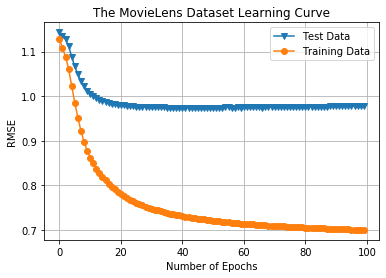

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 15, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
#algorithm_instances_item = [popularity_recsys, 
                      #  average_user_rating_recsys, 
                      #  user_cosine_recsys]  
algorithm_instances_all = [popularity_recsys, 
                           average_user_rating_recsys, 
                           user_cosine_recsys,
                           item_cosine_recsys,
                           pmf]

cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')

In [0]:
algorithm_instances_all

In [0]:
result_patk = cv_patk.run(algorithm_instances_all, num_users, num_items,k=5)
result_ratk = cv_ratk.run(algorithm_instances_all, num_users, num_items,k=5)
result_rmse = cv_rmse.run(algorithm_instances_all, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2107.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2039.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2041.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2027.94it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2054.67it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1979.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2043.11it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2037.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2019.38it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2035.10it/s]


Processing algorithm user-cosine


20000it [00:10, 1967.07it/s]
20000it [00:09, 2016.56it/s]
20000it [00:09, 2079.85it/s]
20000it [00:09, 2006.76it/s]
20000it [00:09, 2061.07it/s]


Processing algorithm item-cosine


20000it [00:09, 2011.76it/s]
20000it [00:09, 2034.25it/s]
20000it [00:09, 2037.58it/s]
20000it [00:09, 2027.53it/s]
20000it [00:09, 2020.97it/s]


Processing algorithm PMF


20000it [00:17, 1159.65it/s]
20000it [00:17, 1137.79it/s]
20000it [00:17, 1147.89it/s]
20000it [00:17, 1174.43it/s]
20000it [00:16, 1184.06it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2086.75it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2044.34it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2068.63it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2056.82it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2073.34it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2074.51it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2078.70it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2075.27it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2106.20it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2038.12it/s]


Processing algorithm user-cosine


20000it [00:09, 2053.68it/s]
20000it [00:09, 2050.05it/s]
20000it [00:09, 2050.18it/s]
20000it [00:09, 2014.04it/s]
20000it [00:09, 2054.04it/s]


Processing algorithm item-cosine


20000it [00:09, 2072.52it/s]
20000it [00:09, 2054.67it/s]
20000it [00:09, 2018.60it/s]
20000it [00:09, 2059.76it/s]
20000it [00:09, 2066.35it/s]


Processing algorithm PMF


20000it [00:17, 1171.18it/s]
20000it [00:17, 1174.31it/s]
20000it [00:16, 1178.10it/s]
20000it [00:17, 1167.57it/s]
20000it [00:17, 1148.22it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2048.89it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2032.45it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2046.00it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2043.21it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2064.99it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2029.95it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2015.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2052.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2021.88it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2041.67it/s]


Processing algorithm user-cosine


20000it [00:09, 2033.91it/s]
20000it [00:09, 2022.18it/s]
20000it [00:10, 1965.03it/s]
20000it [00:09, 2003.58it/s]
20000it [00:09, 2023.15it/s]


Processing algorithm item-cosine


20000it [00:09, 2041.19it/s]
20000it [00:09, 2025.76it/s]
20000it [00:09, 2009.80it/s]
20000it [00:09, 2043.29it/s]
20000it [00:09, 2038.87it/s]


Processing algorithm PMF


20000it [00:17, 1163.30it/s]
20000it [00:17, 1167.08it/s]
20000it [00:17, 1152.73it/s]
20000it [00:17, 1150.51it/s]
20000it [00:16, 1191.23it/s]


In [0]:
result_patk

{'PMF': [[0.3437963944856847,
   0.4865323435843068,
   0.5881230116649007,
   0.6237539766702025,
   0.6065747613997886],
  0.5297560975609766,
  0.3846981873156694,
  0.6748140078062839],
 'item-cosine': [[0.34316012725344736,
   0.483563096500532,
   0.6021208907741271,
   0.6248144220572649,
   0.6074231177094392],
  0.5322163308589621,
  0.3837005215009889,
  0.6807321402169354],
 'popularity': [[0.36924708377518656,
   0.4965005302226948,
   0.6152704135737019,
   0.6426299045599162,
   0.6292682926829279],
  0.5505832449628855,
  0.40544114481568705,
  0.6957253451100839],
 'user-cosine': [[0.37179215270413657,
   0.503923647932133,
   0.621633085896077,
   0.6483563096500541,
   0.6335100742311777],
  0.5558430540827157,
  0.40959849499983714,
  0.7020876131655943],
 'useraverage': [[0.30604453870625714,
   0.4305408271474029,
   0.5321314952279973,
   0.5520678685047737,
   0.5474019088016986],
  0.4736373276776259,
  0.3419993013451059,
  0.6052753540101459]}

In [0]:
print('Method\t\tMean\t\t\tCI')
print('Metric: Precison@K')
for k, v in result_patk.items():
    print('%s \t%f\t%f\t%f'% (k, v[1], v[2], v[3]))
print('\n')
print('Metric: Recall@K')
for k, v in result_ratk.items():
    print('%s \t%f\t%f\t%f'% (k, v[1], v[2], v[3]))
print('\n')
print('Metric: RMSE')
for k, v in result_rmse.items():
    print('%s \t%f\t%f\t%f'% (k, v[1], v[2], v[3]))

Method		Mean			CI
Metric: Precison@K
popularity 	0.550583	0.405441	0.695725
useraverage 	0.473637	0.341999	0.605275
user-cosine 	0.555843	0.409598	0.702088
item-cosine 	0.532216	0.383701	0.680732
PMF 	0.529756	0.384698	0.674814


Metric: Recall@K
popularity 	0.484076	0.367137	0.601014
useraverage 	0.441323	0.329310	0.553336
user-cosine 	0.486269	0.369447	0.603090
item-cosine 	0.474971	0.353573	0.596369
PMF 	0.469291	0.352541	0.586041


Metric: RMSE
popularity 	3.159093	3.139293	3.178893
useraverage 	1.043718	1.028930	1.058505
user-cosine 	1.017354	1.009013	1.025695
item-cosine 	1.020083	1.006824	1.033342
PMF 	0.999062	0.982171	1.015954


### (b) 
Popularity cannot be evaluated by RMSE. The result of popularity is a rate between the number of people who liked the item and the number of the people who rated the item. It doesn't make sense to compare the test set with the actual rating with the popularity matrix.
### (c) 


*   **User-user cosine** did the best on P@K and R@K, while **PMF** did the best on RMSE. 
*   Both **User Average** and **Popularity** are not personalized enough. Popularity rated each item that was not rated by the user by calculating the rate between the number of people who liked the item and the number of the people who rated the item. User average took the average ratings of all users but it is very unlikely that the user will rate the same.
*   **Item-item cosine** did fairly well but the number of items is so much more than the number of users, which makes the rating for items sparse to a point where it is less predictive than user-user cosine.  
*   **PMF** did well on RMSE because the model is optimised with gradient descent using RMSE as the metric.





## Q6

### (a) The three movies I picked
257|Men in Black (1997)|04-Jul-1997||http://us.imdb.com/M/title-exact?Men+in+Black+(1997)|0|1|1|0|0|1|0|0|0|0|0|0|0|0|0|1|0|0|0
225|101 Dalmatians (1996)|27-Nov-1996||http://us.imdb.com/M/title-exact?101%20Dalmatians%20(1996)|0|0|0|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0

1129|Chungking Express (1994)|16-Feb-1996||http://us.imdb.com/M/title-exact?Chongqing%20Senlin%20(1994)|0|0|0|0|0|0|0|0|1|0|0|0|0|1|1|0|0|0|0


In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
                'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
                'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
moviesDF[moviesDF.movieID == 257]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
256,257,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [0]:
#by using movie similarity score, see which movies is more similar than other 
train_matrix = dataPreprocessor(rating_df, num_users, num_items)
ii_similarity = SimBasedRecSys.cosine(train_matrix.transpose())#movie as roll

for id in [225, 257, 1129]:
    top5_index = np.argsort(ii_similarity[id-1])[-6:-1][::-1] #id starts with 0, argsort from big to small, sort backwards, [::-1] sort from big to small 
    name = moviesDF.movieTitle[id-1]
    print("----- movie %s-------" % name)
    for top_index in top5_index:
        print("%s: %f" % (moviesDF.movieTitle[top_index], ii_similarity[id-1][top_index]))
    
    print('\n')

----- movie 101 Dalmatians (1996)-------
Jack (1996): 0.447883
Twister (1996): 0.441882
Willy Wonka and the Chocolate Factory (1971): 0.423295
Independence Day (ID4) (1996): 0.420642
Toy Story (1995): 0.409386


----- movie Men in Black (1997)-------
Return of the Jedi (1983): 0.640674
Star Wars (1977): 0.634035
Independence Day (ID4) (1996): 0.623008
Toy Story (1995): 0.591641
Star Trek: First Contact (1996): 0.586286


----- movie Chungking Express (1994)-------
Hard Eight (1996): 0.400012
I Shot Andy Warhol (1996): 0.340117
Fille seule, La (A Single Girl) (1995): 0.332347
Hate (Haine, La) (1995): 0.330868
Young Poisoner's Handbook, The (1995): 0.327019




### (b)
The movie recommended are of smiliar types. The similarity score is based on all users' ratings of movies and is determined by if they treat both movies in the same way (rate the same score). For people who hate "Man in Black", they are likely to rate similar types of movie low, for example, Sci-Fi and adventure movies.

## Q7

### (a)

(array([331., 152.,  75.,  68.,  53.,  52.,  35.,  35.,  29.,  24.,  17.,
         18.,  12.,   9.,   7.,   8.,   5.,   3.,   1.,   1.,   3.,   1.,
          1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.]),
 array([ 20.        ,  43.12903226,  66.25806452,  89.38709677,
        112.51612903, 135.64516129, 158.77419355, 181.90322581,
        205.03225806, 228.16129032, 251.29032258, 274.41935484,
        297.5483871 , 320.67741935, 343.80645161, 366.93548387,
        390.06451613, 413.19354839, 436.32258065, 459.4516129 ,
        482.58064516, 505.70967742, 528.83870968, 551.96774194,
        575.09677419, 598.22580645, 621.35483871, 644.48387097,
        667.61290323, 690.74193548, 713.87096774, 737.        ]),
 <a list of 31 Patch objects>)

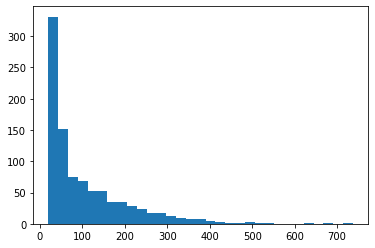

In [9]:
matrix = dataPreprocessor(rating_df, num_users, num_items)
matrix[matrix.nonzero()] = 1
count = np.sum(matrix, axis=1)
#count = np.hstack(count)
plt.hist(count, bins='auto')

In [36]:
thre = 66
# train_matrix = dataPreprocessor(rating_df, num_users, num_items)
# user_id_list_above_thre = [i for i in range(len(count)) if count[i] >= thre] #ID-1
# matrix = pd.DataFrame(matrix)
# user_id_list_below_thre = [ind for ind in matrix.index.tolist() if ind not in user_id_list_above_thre] #ID-1
train_matrix_above = train_matrix[count>=thre]
train_matrix_below = train_matrix[count<thre]
train_matrix_above.shape
train_matrix_below.shape

(477, 1682)

In [0]:
def predict_uu(train_matrix): 
            
    uu_similarity = SimBasedRecSys.cosine(train_matrix)
    temp_matrix = np.zeros(train_matrix.shape)
    temp_matrix[train_matrix.nonzero()] = 1
    
    normalizer = np.matmul(uu_similarity, temp_matrix) #number of users*number of items
    normalizer[normalizer == 0] = 1e-5 #10**-5
            
    predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer 
           
    useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5) #axis=1 tuple横着加 sum of user rating/#user
    columns = np.sum(predictionMatrix, axis=0) #sum of ratings for each item #1*number of items
         
    predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
                                             #columns这个matrix数列里数字是0的index对应的predictionMatrix
    return predictionMatrix
        
def predict_ii(train_matrix):
    
    train_matrix = train_matrix.T
    ii_similarity = SimBasedRecSys.cosine(train_matrix)  #similarity of items
             
    temp_matrix = np.zeros(train_matrix.shape)
    temp_matrix[train_matrix.nonzero()] = 1
            
    normalizer = np.matmul(ii_similarity, temp_matrix) #number of users*number of items
    normalizer[normalizer == 0] = 1e-5 #10**-5
    
    predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer #why do we need a normalizer?
           
    itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5) #axis=1 tuple横着加 sum of user rating/#user
    columns = np.sum(predictionMatrix, axis=0) #sum of ratings for each item #1*number of items

    predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
                                             #columns这个matrix数列里数字是0的index对应的predictionMatrix

    return predictionMatrix.T


def rmse(prediction, real):
    prediction = prediction[real.nonzero()].flatten() 
    real = real[real.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, real))


In [0]:
above_thre_uu = predict_uu(train_matrix_above)
below_thre_uu = predict_uu(train_matrix_below)
above_thre_ii = predict_ii(train_matrix_above)
below_thre_ii = predict_ii(train_matrix_below)

In [0]:
rmse_above_thre_uu = rmse(above_thre_uu, train_matrix_above)
rmse_below_thre_uu = rmse(below_thre_uu, train_matrix_below)
rmse_above_thre_ii = rmse(above_thre_ii, train_matrix_above)
rmse_below_thre_ii = rmse(below_thre_ii, train_matrix_below)

In [44]:
print('User based: above threshold: %f, below threshold: %f' % (rmse_above_thre_uu,rmse_below_thre_uu ))
print('Item based: above threshold: %f, below threshold: %f' % (rmse_above_thre_ii,rmse_below_thre_ii))

User based: above threshold: 0.949731, below threshold: 0.872217
Item based: above threshold: 0.990059, below threshold: 0.875874


For both user based method and item based method, the model with users with a large to moderate number of ratings did better than that with a few. Becase the similarity is determined by if users treat both movies in the same way (rate the same score). This requires a large number of item data for each user in order for the model to have a better performance.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)